In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [2]:
from google.colab import drive
import glob
import json
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [3]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [4]:
using_colab = True

In [5]:
#if using_colab:
#    import torch
#    import torchvision
#    print("PyTorch version:", torch.__version__)
#    print("Torchvision version:", torchvision.__version__)
#    print("CUDA is available:", torch.cuda.is_available())
#    import sys
#    !{sys.executable} -m pip install opencv-python matplotlib
#    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#    !mkdir images
#    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

#    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-4v1l8z76
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-4v1l8z76
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.8 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=473713 sha256=7cedb25341e5b57af4e910e36010b2989213a0c30dd26dc6eb8a8ea48e1ac06f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pn2fejz0/wheels/25/a3/8a/abd69dc6a6926b5e75c24

## Set-up

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [15]:
#def show_anns(anns):
#    if len(anns) == 0:
#        return
#    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
#    ax = plt.gca()
#    ax.set_autoscale_on(False)

#    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
#    img[:,:,3] = 0
#    for ann in sorted_anns:
#        m = ann['segmentation']
#        color_mask = np.concatenate([np.random.random(3), [0.35]])
#        img[m] = color_mask
#    ax.imshow(img)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [7]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## Example image

In [8]:
#image = cv2.imread('images/dog.jpg')
image = cv2.imread('/content/drive/MyDrive/katieData/112.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

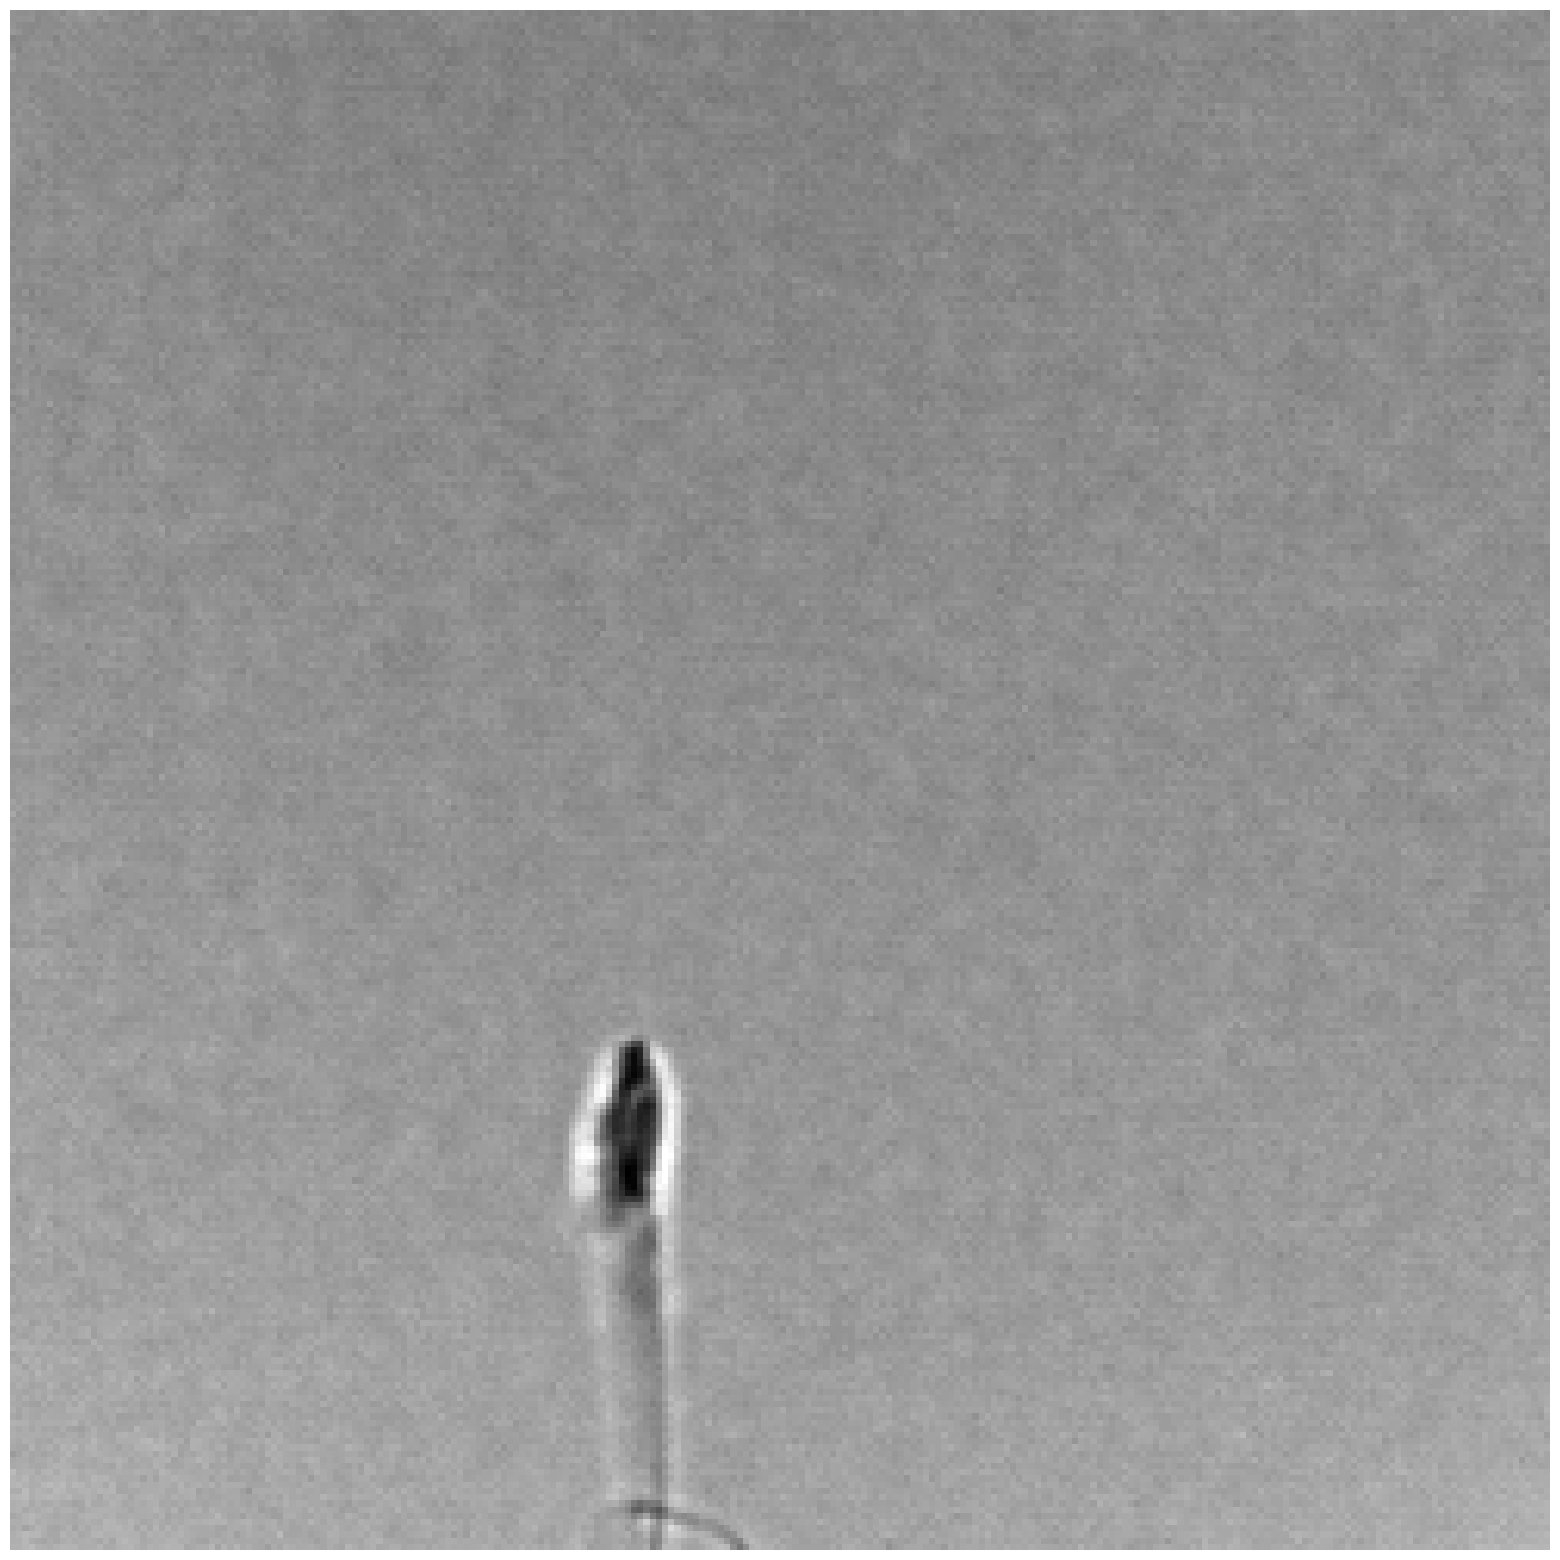

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [25]:
all_images = glob.glob('/content/drive/MyDrive/katieData/*.tif')[0:100]
#all_images = ['/content/drive/MyDrive/katieData/122.tif']
#print(all_images)

print(all_images[0].split('/')[-1][:-4])

148


In [ ]:
for one_image in all_images:
  print(one_image)
  #Load Image
  image = cv2.imread(one_image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Segment Image
  masks = mask_generator_2.generate(image)

  print(masks[0])

  cnt = 0
  for mask in masks:
    #grab the segmentation and save an as image
    mask_image = (mask['segmentation'] * 255).astype(np.uint8)  # Convert to uint8 format
    cv2.imwrite('/content/drive/MyDrive/Segmentations/' + one_image.split('/')[-1][:-4] + '_' + str(cnt) + '.png', mask_image)
    cnt += 1

  #cnt = 0
  #for mask in masks:
  #  # Save off image segment as json
  #  with open('/content/drive/MyDrive/Segmentations/' + one_image.split('/')[-1][:-4] + '_' + str(cnt) + '.json', 'w') as f:
  #    json.dump(mask, f, indent=4) # indent=4 makes the JSON output more readable
  #  cnt += 1

  # Now save the png
  fig = plt.figure()
  #plt.figure(figsize=(20,20))
  plt.imshow(image)
  show_anns(masks)
  plt.axis('off')
  #plt.show()
  plt.savefig('/content/drive/MyDrive/Segmentations/' + one_image.split('/')[-1][:-4] + '.jpg')
  plt.close(fig)

/content/drive/MyDrive/katieData/148.tif
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 239, 'bbox': [127.0, 194.0, 15.0, 18.0], 'predicted_iou': 0.921875, 'point_coords': [[131.8000030517578, 198.1999969482422]], 'stability_score': 0.9471544623374939, 'crop_box': [82.0, 82.0, 166.0, 166.0]}
/content/drive/MyDrive/katieData/113.tif
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, 

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

4
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

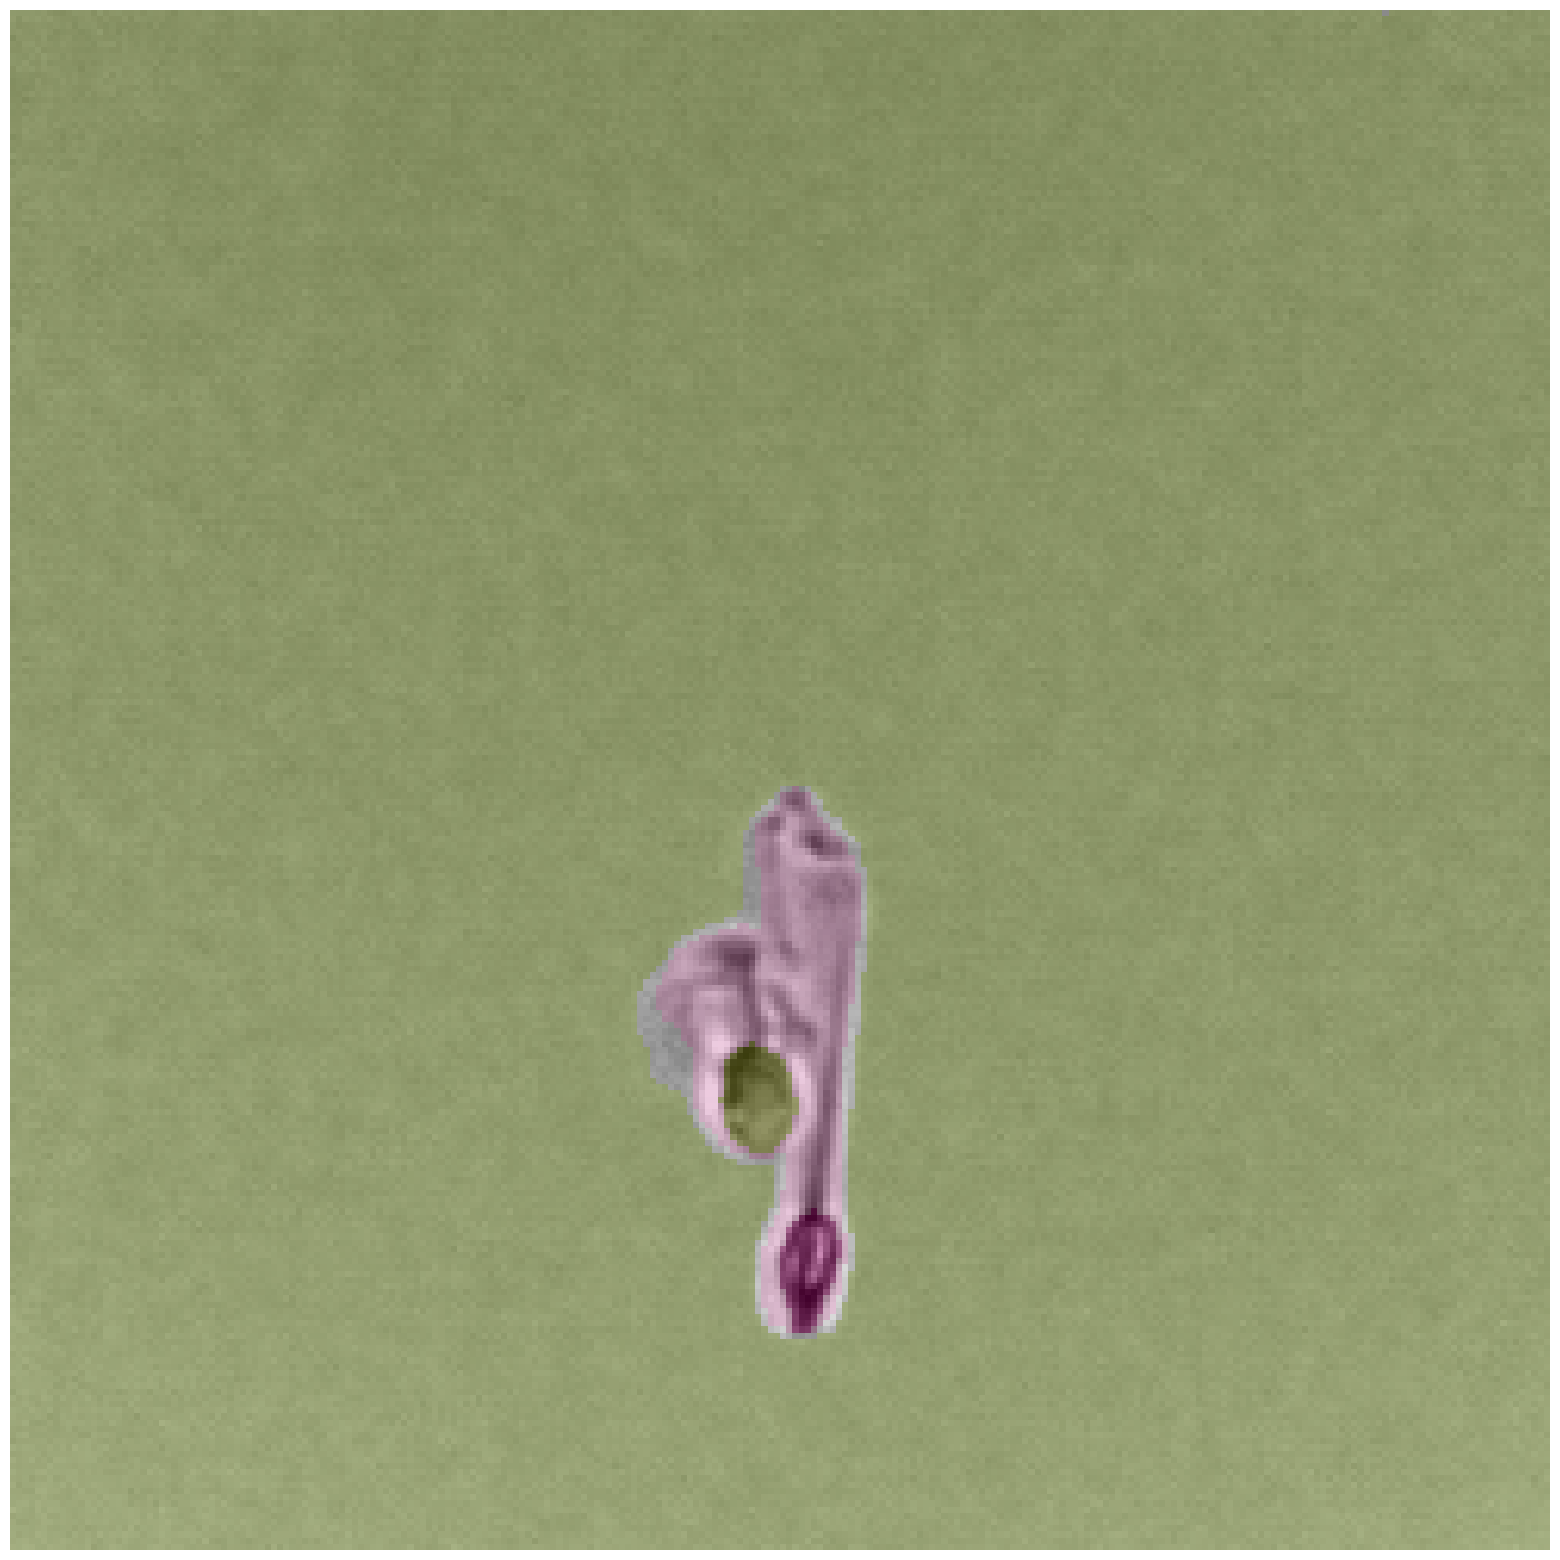

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [21]:
#mask_generator_2 = SamAutomaticMaskGenerator(
#    model=sam,
#    points_per_side=32,
#    pred_iou_thresh=0.86,
#    stability_score_thresh=0.92,
#    crop_n_layers=1,
#    crop_n_points_downscale_factor=2,
#    min_mask_region_area=100,  # Requires open-cv to run post-processing
#)
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=50,
    points_per_batch=100,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.8,
    crop_n_points_downscale_factor=10,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [22]:
masks2 = mask_generator_2.generate(image)

In [23]:
len(masks2)

8

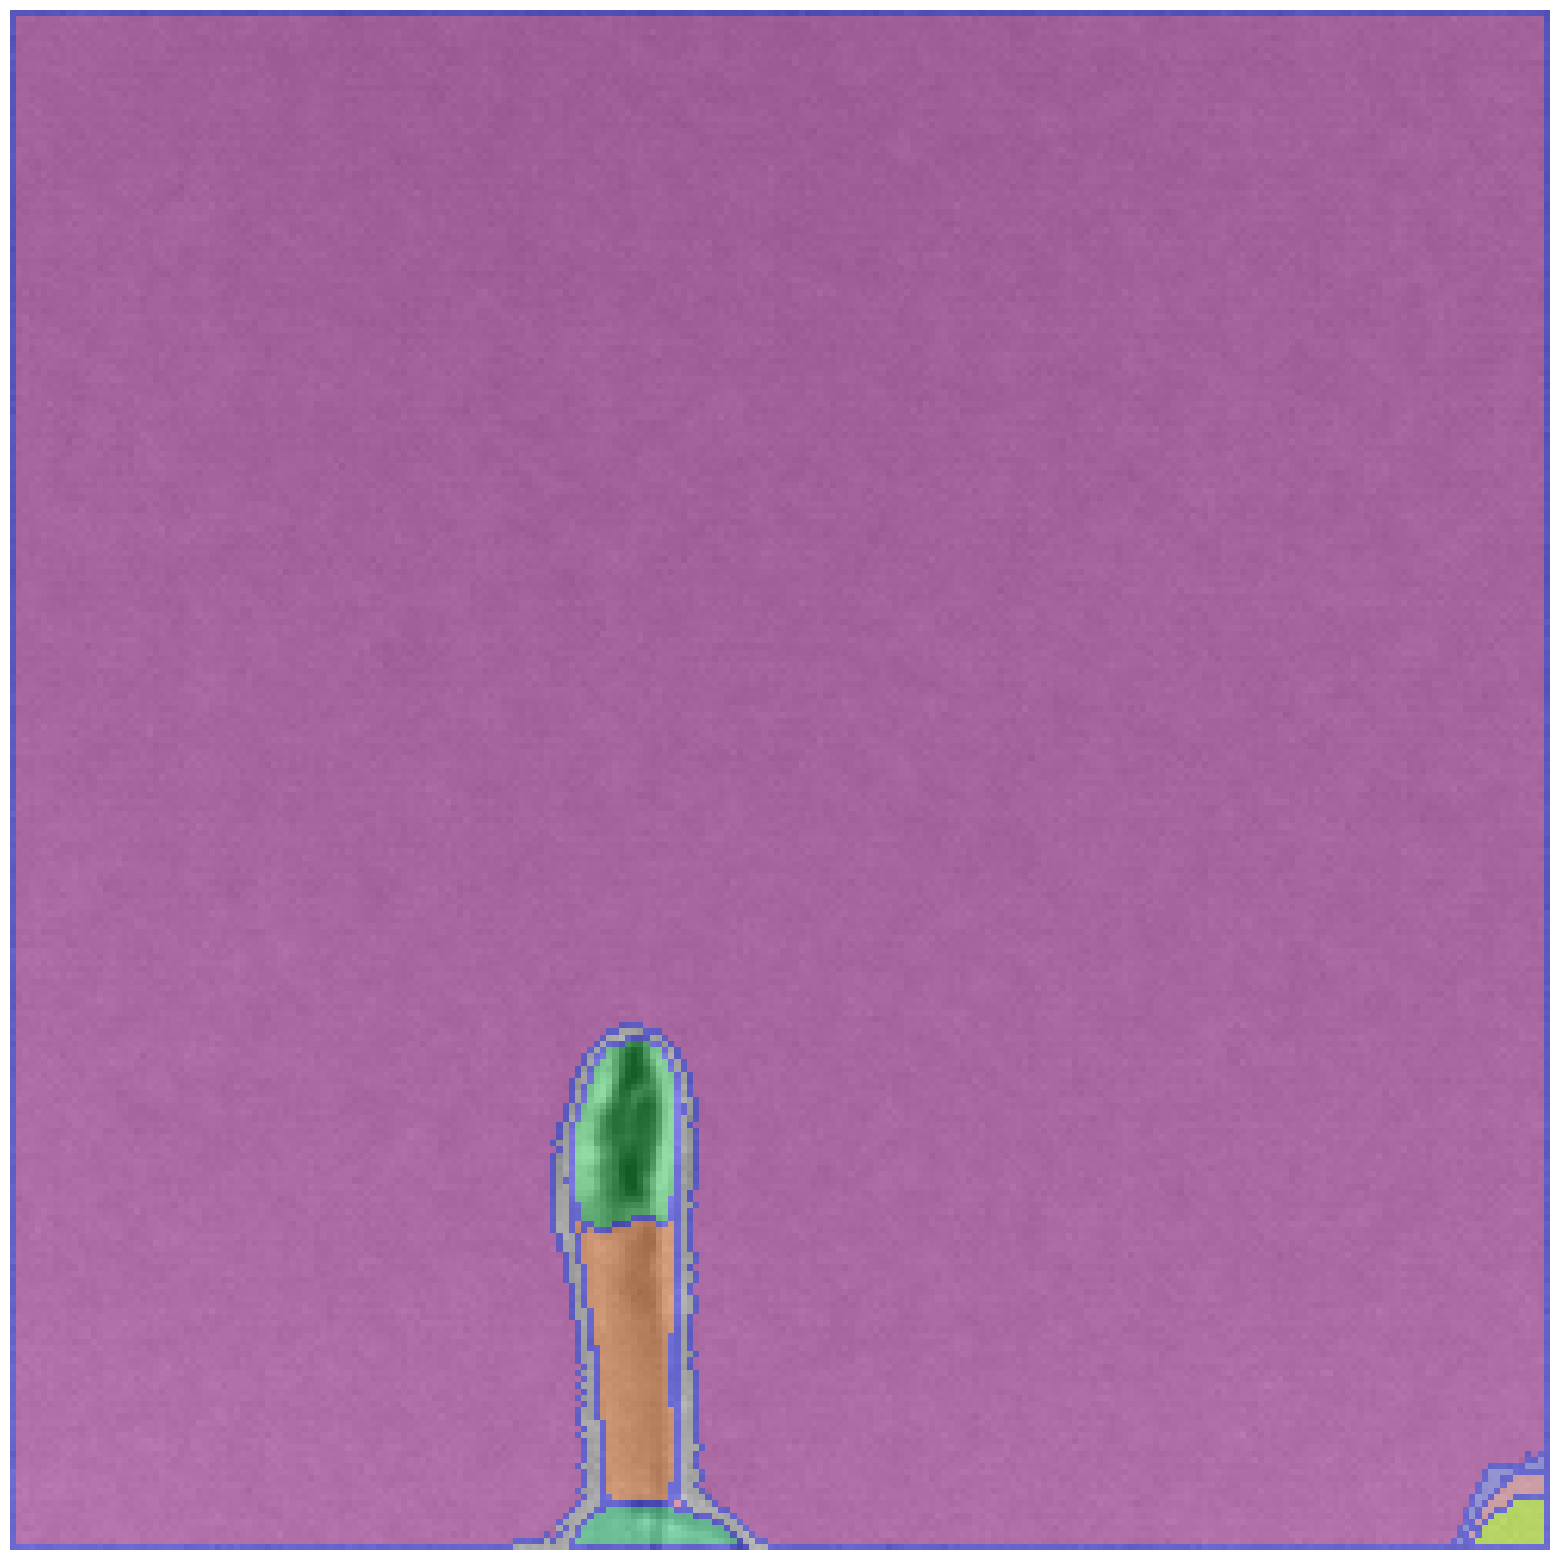

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()